<a href="https://colab.research.google.com/github/Ksenia-90/Machine_learning-_in_business/blob/my/Step1_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Итоговый проект 

#Step1

Обучение пайплайна 
* Загрузим данные https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

* Обучим логистическую регрессию и сохраним на диск предобученный пайплайн

In [124]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [125]:
import pandas as pd
import numpy as np
import dill
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import xgboost as xgbclassifier 
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn.metrics import roc_auc_score,roc_curve
dill._dill._reverse_typemap['ClassType'] = type

import matplotlib.pyplot as plt

%matplotlib inline

In [126]:
#df = pd.read_csv("churn_data.csv")

df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [127]:
df.shape

(10000, 14)

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [129]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [130]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

##**EDA**

In [131]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

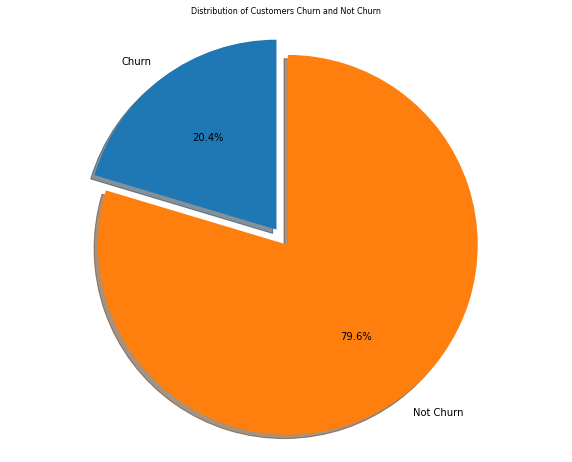

In [132]:
labels = 'Churn', 'Not Churn'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Distribution of Customers Churn and Not Churn", size = 8)
plt.show()


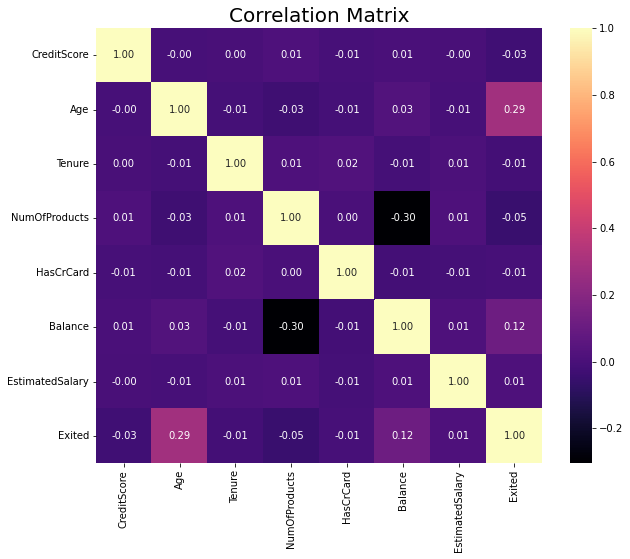

In [133]:
f, ax = plt.subplots(figsize= [10,8])
g = sns.heatmap(df[["CreditScore","Age","Tenure","NumOfProducts","HasCrCard","Balance", "EstimatedSalary", "Exited"]].corr(),annot=True, fmt = ".2f", ax=ax, cmap = "magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


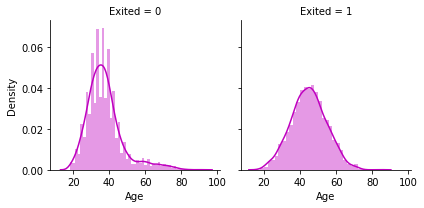

In [134]:
g = sns.FacetGrid(df, col='Exited')
g = g.map(sns.distplot, "Age", color="m")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


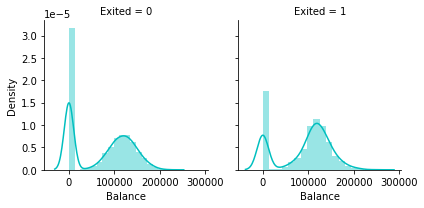

In [135]:
g = sns.FacetGrid(df, col='Exited')
g = g.map(sns.distplot, "Balance", color="c")

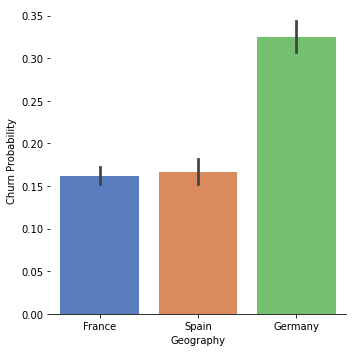

In [136]:
g = sns.catplot(x="Geography",y="Exited", data=df, kind="bar", height = 5 ,palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Churn Probability")

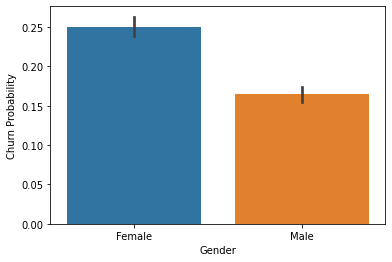

In [137]:
g = sns.barplot(x="Gender",y="Exited",data=df)
g = g.set_ylabel("Churn Probability")

In [138]:
y = df["Exited"]

X = df.drop(labels = ["Exited"],axis = 1)

In [139]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], test_size=0.33, random_state=42)
#save test
X_test.to_csv("X_test.csv", index=None)
y_test.to_csv("y_test.csv", index=None)
#save train
X_train.to_csv("X_train.csv", index=None)
y_train.to_csv("y_train.csv", index=None)

In [140]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [141]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [142]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [143]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
               ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
6252,0,1
4684,0,1
1731,1,0


In [144]:
feats = FeatureUnion([('Gender', gender)
                    ])

In [145]:
from sklearn.preprocessing import StandardScaler

In [146]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)), 
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [147]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [148]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [149]:
with open("logreg_pipeline.dill", "wb") as f:
    dill.dump(pipeline, f)

#Step 2

In [150]:
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve
import dill
dill._dill._reverse_typemap['ClassType'] = type

In [151]:
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

In [152]:
X_test.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,6253,15687492,Anderson,596,Germany,Male,32,3,96709.07,2,0,0,41788.37,0
1,4685,15736963,Herring,623,France,Male,43,1,0.00,2,1,1,146379.30,0
2,1732,15721730,Amechi,601,Spain,Female,44,4,0.00,2,1,0,58561.31,0


In [153]:
with open('logreg_pipeline.dill', 'rb') as in_strm:
    pipeline = dill.load(in_strm)

In [154]:
predictions = pipeline.predict_proba(X_test)
pd.DataFrame({'preds': predictions[:, 1]}).to_csv("test_predictions.csv", index=None)

In [155]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [157]:
preds = pipeline.predict_proba(X_test)[:, 1]

In [158]:

precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.286206, F-Score=0.638, Precision=0.609, Recall=0.670


In [159]:
roc_auc_score(y_score=predictions[:, 1][:], y_true=y_test.iloc[:])

0.8679888975452031

#Step 3

In [123]:
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve
from urllib import request, parse

X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

In [83]:
import urllib.request
import json      

def get_prediction(gender):
    body = {'Gender': gender}

    myurl = "http://0.0.0.0:8180/predict"
    req = urllib.request.Request(myurl)
    req.add_header('Content-Type', 'application/json; charset=utf-8')
    jsondata = json.dumps(body)
    jsondataasbytes = jsondata.encode('utf-8')   # needs to be bytes
    req.add_header('Content-Length', len(jsondataasbytes))
    #print (jsondataasbytes)
    response = urllib.request.urlopen(req, jsondataasbytes)
    return json.loads(response.read())['predictions']

In [87]:
get_prediction('free ')

URLError: ignored

In [ ]:
%%time
predictions = X_test[['description', 'company_profile', 'benefits']].iloc[:500].apply(lambda x: get_prediction(x[0], 
                                                                                               x[1], 
                                                                                               x[2]), 1)

In [ ]:
roc_auc_score(y_score=predictions.values, y_true=y_test.iloc[:500])

In [ ]:
get_prediction("", "", None)